In [1]:
import time
import inspect
import numpy as np
import pandas as pd
from tqdm import tqdm
from utils import preprocess, features, classifier, metrics, logging

In [2]:
seed = 42
np.random.seed(seed)
models_path = 'models'  # folder of models

In [3]:
# logger2 = logging.Logger('log/log2.csv')
# logger2.leadboard(col='val_score', top=5)
# logger2.init_log()

In [5]:
# logger1 = logging.Logger('log/log1.csv')
# logger1.leadboard(col='val_score', top=10)
# logger1.init_log()

In [6]:
def load_datasets():
#     train_dataset = preprocess.Dataset('data/train1.wtag')
#     val_dataset = preprocess.Dataset('data/comp1_tagged.wtag')

    train_dataset = preprocess.Dataset('data/train2.wtag')
    val_dataset = preprocess.Dataset('data/comp2_tagged.wtag')
    return train_dataset, val_dataset

train_dataset, val_dataset = load_datasets()
tags = train_dataset.tags.union(val_dataset.tags)

In [7]:
def create_feats(prints=True):
    group_thresholds = {
        # -------------------------------- feature --------------------- | -- Threshold --
        lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,     # mandatory feature f100
        lambda t2, t1, w, i, t: tuple([w[i][-4:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-3:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-2:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][-1:].lower(), t]):                    5,     # mandatory feature f101
        lambda t2, t1, w, i, t: tuple([w[i][:4].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:3].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:2].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([w[i][:1].lower(), t]):                     5,     # mandatory feature f102
        lambda t2, t1, w, i, t: tuple([t2, t1, t]):                               1,     # mandatory feature f103
        lambda t2, t1, w, i, t: tuple([t1, t]):                                   1,     # mandatory feature f104
        lambda t2, t1, w, i, t: tuple([t]):                                       1,     # mandatory feature f105
        lambda t2, t1, w, i, t: tuple([w[i].islower(), t]):                       1,     # mandatory feature has_uppercase
        lambda t2, t1, w, i, t: tuple([any(char.isdigit() for char in w[i]), t]): 1,     # mandatory feature has_digits
        lambda t2, t1, w, i, t: tuple([w[i-1].lower(), t]):                       20,
        lambda t2, t1, w, i, t: tuple([w[i+1].lower(), t]):                       20,
        lambda t2, t1, w, i, t: tuple([w[i+1][:3].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i-1][:3].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i+1][:2].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i-1][:2].lower(), t]):                   20,
        lambda t2, t1, w, i, t: tuple([w[i+1][-3:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i-1][-3:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i+1][-2:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i-1][-2:].lower(), t]):                  20,
        lambda t2, t1, w, i, t: tuple([w[i].isalnum(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isalpha(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isascii(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isdecimal(), t]):                     10,
        lambda t2, t1, w, i, t: tuple([w[i].isdigit(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isnumeric(), t]):                     10,
        lambda t2, t1, w, i, t: tuple([w[i].istitle(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([w[i].isupper(), t]):                       10,
        lambda t2, t1, w, i, t: tuple([len(w[i]), t]):                            10,
    }

    tic = time.time()
    feature_vector = features.create_feature_vector(dataset=train_dataset,
                                                    group_thresholds=group_thresholds,
                                                    pruning=True,
                                                    get_stats=False,
                                                    assertions=True,
                                                    calls_counter=False)

    if prints:
        print('feature_vector creation time:', time.time() - tic, 'sec\n')
        for feat in feature_vector.feats:
            print('feat_group:', feat, '| feats:', len(feat))
    print('feat_groups:', len(feature_vector.feats), '| total_feats:', len(feature_vector))
    return feature_vector

feature_vector = create_feats(prints=True)

feature_vector creation time: 0.16922855377197266 sec

feat_group: FeatureGroup(tuple([w[i].lower(), t])) | feats: 1736
feat_group: FeatureGroup(tuple([w[i][-4:].lower(), t])) | feats: 170
feat_group: FeatureGroup(tuple([w[i][-3:].lower(), t])) | feats: 165
feat_group: FeatureGroup(tuple([w[i][-2:].lower(), t])) | feats: 145
feat_group: FeatureGroup(tuple([w[i][-1:].lower(), t])) | feats: 96
feat_group: FeatureGroup(tuple([w[i][:4].lower(), t])) | feats: 158
feat_group: FeatureGroup(tuple([w[i][:3].lower(), t])) | feats: 170
feat_group: FeatureGroup(tuple([w[i][:2].lower(), t])) | feats: 200
feat_group: FeatureGroup(tuple([w[i][:1].lower(), t])) | feats: 133
feat_group: FeatureGroup(tuple([t2, t1, t])) | feats: 598
feat_group: FeatureGroup(tuple([t1, t])) | feats: 216
feat_group: FeatureGroup(tuple([t])) | feats: 31
feat_group: FeatureGroup(tuple([w[i].islower(), t])) | feats: 43
feat_group: FeatureGroup(tuple([any(char.isdigit() for char in w[i]), t])) | feats: 35
feat_group: FeatureG

In [8]:
# def create_feats(prints=True):
#     group_thresholds = {
#         # -------------------------------- feature --------------------- | -- Threshold --
#         lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,     # mandatory feature f100
#         lambda t2, t1, w, i, t: tuple([w[i][-4:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-3:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-2:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-1:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][:4].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:3].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:2].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:1].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([t2, t1, t]):                               1,     # mandatory feature f103
#         lambda t2, t1, w, i, t: tuple([t1, t]):                                   1,     # mandatory feature f104
#         lambda t2, t1, w, i, t: tuple([t]):                                       1,     # mandatory feature f105
#         lambda t2, t1, w, i, t: tuple([w[i].islower(), t]):                       1,     # mandatory feature has_uppercase (inverted)
#         lambda t2, t1, w, i, t: tuple([any(char.isdigit() for char in w[i]), t]): 1,     # mandatory feature has_digits
#         lambda t2, t1, w, i, t: tuple([w[i-1].lower(), t]):                       20,
#         lambda t2, t1, w, i, t: tuple([w[i+1].lower(), t]):                       20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][:3].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][:3].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][:2].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][:2].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][-3:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][-3:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][-2:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][-2:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i].isalnum(), t]):                       1,
#         lambda t2, t1, w, i, t: tuple([w[i].isalpha(), t]):                       1,
#         lambda t2, t1, w, i, t: tuple([w[i].isascii(), t]):                       1,
#         lambda t2, t1, w, i, t: tuple([w[i].isdecimal(), t]):                     1,
#         lambda t2, t1, w, i, t: tuple([w[i].isdigit(), t]):                       1,
#         lambda t2, t1, w, i, t: tuple([w[i].isnumeric(), t]):                     1,
#         lambda t2, t1, w, i, t: tuple([w[i].istitle(), t]):                       1,
#         lambda t2, t1, w, i, t: tuple([w[i].isupper(), t]):                       1,
#         lambda t2, t1, w, i, t: tuple([len(w[i]), t]):                            1,
#     }

#     tic = time.time()
#     feature_vector = features.create_feature_vector(dataset=train_dataset,
#                                                     group_thresholds=group_thresholds,
#                                                     pruning=True,
#                                                     get_stats=False,
#                                                     assertions=True,
#                                                     calls_counter=False)

#     if prints:
#         print('feature_vector creation time:', time.time() - tic, 'sec\n')
#         for feat in feature_vector.feats:
#             print('feat_group:', feat, '| feats:', len(feat))
#     print('feat_groups:', len(feature_vector.feats), '| total_feats:', len(feature_vector))
#     return feature_vector

# feature_vector = create_feats(prints=True)

In [9]:
# def create_feats(prints=True):
#     group_thresholds = {
#         # -------------------------------- feature --------------------- | -- Threshold --
#         lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,     # mandatory feature f100
# #         lambda t2, t1, w, i, t: tuple([w[i-1].lower(), w[i].lower(), w[i+1].lower(), t]):                 10,
# #         lambda t2, t1, w, i, t: tuple([w[i-2].lower(), w[i-1].lower(), w[i].lower(), t]):                 10,
# #         lambda t2, t1, w, i, t: tuple([w[i].lower(), w[i+1].lower(), w[i+2].lower(), t]):                 10,
#         lambda t2, t1, w, i, t: tuple([w[i].lower(), t]):                         0,
#         lambda t2, t1, w, i, t: tuple([w[i][-4:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-3:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-2:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][-1:].lower(), t]):                    5,     # mandatory feature f101
#         lambda t2, t1, w, i, t: tuple([w[i][:4].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:3].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:2].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([w[i][:1].lower(), t]):                     5,     # mandatory feature f102
#         lambda t2, t1, w, i, t: tuple([t2, t1, t]):                               1,     # mandatory feature f103
#         lambda t2, t1, w, i, t: tuple([t1, t]):                                   1,     # mandatory feature f104
#         lambda t2, t1, w, i, t: tuple([t]):                                       0,     # mandatory feature f105
#         lambda t2, t1, w, i, t: tuple([w[i].islower(), t]):                       0,     # mandatory feature has_uppercase (inverted)
#         lambda t2, t1, w, i, t: tuple([any(char.isdigit() for char in w[i]), t]): 0,     # mandatory feature has_digits
#         lambda t2, t1, w, i, t: tuple([w[i-1].lower(), t]):                       20,
#         lambda t2, t1, w, i, t: tuple([w[i+1].lower(), t]):                       20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][:3].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][:3].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][:2].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][:2].lower(), t]):                   20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][-3:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][-3:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i+1][-2:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i-1][-2:].lower(), t]):                  20,
#         lambda t2, t1, w, i, t: tuple([w[i].isalnum(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isalpha(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isascii(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isdecimal(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i].isdigit(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isnumeric(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i].istitle(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple([w[i].isupper(), t]):                       0,
#         lambda t2, t1, w, i, t: tuple(['-' in w[i], t]):                          0,
#         lambda t2, t1, w, i, t: tuple(['.' in w[i], t]):                          0,
#         lambda t2, t1, w, i, t: tuple([',' in w[i], t]):                          0,
#         lambda t2, t1, w, i, t: tuple(['\/' in w[i], t]):                         0,
#         lambda t2, t1, w, i, t: tuple([len(w[i]), t]):                            0,
#         lambda t2, t1, w, i, t: tuple([len(w), t]):                               5,
#         lambda t2, t1, w, i, t: tuple([i, t]):                                    10,
#         lambda t2, t1, w, i, t: tuple([i==len(w)-1, t]):                          0,

#         lambda t2, t1, w, i, t: tuple([w[i-1].isalnum(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isalpha(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isascii(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isdecimal(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isdigit(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isnumeric(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].istitle(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i-1].isupper(), t]):                     0,

#         lambda t2, t1, w, i, t: tuple([w[i+1].isalnum(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isalpha(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isascii(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isdecimal(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isdigit(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isnumeric(), t]):                   0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].istitle(), t]):                     0,
#         lambda t2, t1, w, i, t: tuple([w[i+1].isupper(), t]):                     0,
#     }

#     tic = time.time()
#     feature_vector = features.create_feature_vector(dataset=train_dataset,
#                                                     group_thresholds=group_thresholds,
#                                                     pruning=True,
#                                                     get_stats=False,
#                                                     assertions=True,
#                                                     calls_counter=False)

#     if prints:
#         print('feature_vector creation time:', time.time() - tic, 'sec\n')
#         for feat in feature_vector.feats:
#             print('feat_group:', feat, '| feats:', len(feat))
#     print('feat_groups:', len(feature_vector.feats), '| total_feats:', len(feature_vector))
#     return feature_vector

# feature_vector = create_feats(prints=True)

In [10]:
# def w0_uniform_0_1_centered_normalized():
#     w0 = np.random.rand(len(feature_vector))
#     w0 -= w0.mean()
#     w0 /= w0.std()
#     return w0

# def w0_uniform_0_1_normalized():
#     w0 = np.random.rand(len(feature_vector))
#     w0 /= w0.std()
#     return w0

# def w0_uniform_0_1_centered():
#     w0 = np.random.rand(len(feature_vector))
#     w0 -= w0.mean()
#     return w0

# def w0_uniform_0_1():
#     return np.random.rand(len(feature_vector))

# def w0_xavier():
#     return np.random.randn(len(feature_vector))*np.sqrt(1/len(feature_vector))

# def w0_zero():
#     return np.zeros(len(feature_vector)).astype(np.float32)

# w0_init = w0_uniform_0_1
# w0 = w0_init()

In [11]:
# model = classifier.load_model(version=12,
#                               models_path=models_path,
#                               epoch=112,
#                               seed=42,
#                               prints=True)

In [12]:
# version = 2.1

# model = classifier.Model(version=version,
#                          w0=w0_init(),
#                          tags=train_dataset.tags,
#                          inference=classifier.viterbi,
#                          feature_vector=feature_vector,
#                          score_func=metrics.accuracy,
#                          models_path=models_path,
#                          max_weights_history=5,
#                          save=False)

# # model.load(weights=True, weights_history=True, feature_vector=True, log=True, epoch=epoch, prints=True)

In [46]:
train_save = True  # save model after each training epoch, if False model will need to be saved manually
beam = 1  # viterbi beam size for model evaluation during training
train_aprox = 0  # aproximate train_score with first train_aprox train samples
val_aprox = 1000  # aproximate val_score with first val_aprox train samples 
weight_decay = 0.0  # lamda regularization parameter
init_batch_size = 250  # batch_size for loader
batch_growth = 0
epochs = 100  # training epochs
tqdm_bar = False  # display tqdm progress bars

v_min, f_min, d_min = model.train(epochs=epochs,
                                  train_dataset=train_dataset,
                                  val_dataset=val_dataset,
                                  batch_size=init_batch_size,
                                  weight_decay=weight_decay,
                                  save=train_save,
                                  tqdm_bar=tqdm_bar,
                                  beam=beam,
                                  train_aprox=train_aprox,
                                  val_aprox=val_aprox,
                                  batch_growth=batch_growth)

epoch  44/143 | train_loss 1.063742 | val_loss 8.247883 | train_score 0.000000 | val_score 0.9264 | train_time  50.15 min
epoch  45/143 | train_loss 1.569618 | val_loss 9.283092 | train_score 0.000000 | val_score 0.9117 | train_time  64.09 min
epoch  46/143 | train_loss 0.971807 | val_loss 8.146290 | train_score 0.000000 | val_score 0.9250 | train_time  78.14 min
epoch  47/143 | train_loss 0.956656 | val_loss 8.116944 | train_score 0.000000 | val_score 0.9250 | train_time  92.07 min
epoch  48/143 | train_loss 0.921604 | val_loss 8.064214 | train_score 0.000000 | val_score 0.9252 | train_time 106.09 min
epoch  49/143 | train_loss 0.899271 | val_loss 8.046641 | train_score 0.000000 | val_score 0.9254 | train_time 120.07 min
epoch  50/143 | train_loss 0.850193 | val_loss 8.040568 | train_score 0.000000 | val_score 0.9252 | train_time 134.08 min


KeyboardInterrupt: 

In [14]:
# # recalculate best INDs
# best_loss = 9999.9
# for i in model.log.index:
#     best = model.log.loc[i]['val_loss'] < best_loss
#     if best:
#         model.log.loc[i, 'best'] = True
#         best_loss = model.log.loc[i]['val_loss']
# model.save(epoch=True)

In [34]:
version = 2.1
weights_history = []
for epoch in [43,42,41,40]:
    model = classifier.load_model(version=version,
                                  models_path=models_path,
                                  epoch=epoch,
                                  seed=42,
                                  prints=False)
    weights_history.append(model.weights)

In [19]:
model.feature_vector = model43.feature_vector

In [45]:
version = 2.1
epoch = 43
model = classifier.load_model(version=version,
                              models_path=models_path,
                              epoch=epoch,
                              seed=42,
                              prints=True)
print(len(model.feature_vector))
print(len(model.weights))

model version: 2.1
epochs: 43
train_time: 36.064

last train_loss: 1.063742
last val_loss: 8.247883
last train_score: 0.000000
last val_score: 0.926393
best val_score: 0.9264 at epoch 28
4548
4548


In [40]:
model.weights

array([0.74132932, 1.04591833, 1.28413936, ..., 1.73102991, 2.84690286,
       1.28347268])

In [41]:
for weights in weights_history:
    print(weights)

[0.74132932 1.04591833 1.28413936 ... 1.73102991 2.84690286 1.28347268]
[0.72027096 1.03981328 1.26418465 ... 1.68628278 2.81311107 1.25848098]
[0.7150308  1.03812774 1.25851461 ... 1.67604707 2.79869899 1.25145026]
[0.70444969 1.03510677 1.24736011 ... 1.65080721 2.7653069  1.23783151]


In [42]:
model.weights_history = weights_history

In [43]:
model.avg_weights(save=True)

In [44]:
aprox_num = 1000  # max samples to aproximate score
display_all = False
beam_stats = {}
dataset = val_dataset

for predict_beam in [1]:  # viterbi beam size
    beam_stats[predict_beam] = {}
    beam_stats[predict_beam]['pred_tags'] = []
    beam_stats[predict_beam]['true_tags'] = []
    pbar = tqdm(dataset.sentences[:aprox_num])
    for sentence in pbar:
        preds = model(sentence[0], predict_beam)
        beam_stats[predict_beam]['pred_tags'].append(preds)
        beam_stats[predict_beam]['true_tags'].append(sentence[1])

        if display_all:
            display(pd.DataFrame((sentence[0], sentence[1], preds), index=('words', 'tags', 'preds')))
        pbar.set_postfix(acc='{:.4f}'.format(model.score_func(beam_stats[predict_beam]['pred_tags'],
                                              beam_stats[predict_beam]['true_tags'])),
                         refresh=False)

    beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = \
                                        metrics.confusion_matrix(tags,
                                                                 beam_stats[predict_beam]['pred_tags'],
                                                                 beam_stats[predict_beam]['true_tags'])
    model.comp_preds = beam_stats
    comp_acc = model.score_func(model.comp_preds[predict_beam]['pred_tags'],
                                model.comp_preds[predict_beam]['true_tags'])
    model.save(manual_path='{}/V{:}/model_V{:}_E0{:}_beam{:}_comp_acc{:.4f}.pth'.format(models_path,
                                                                                        model.version,
                                                                                        model.version,
                                                                                        model.get_log(),
                                                                                        predict_beam,
                                                                                        comp_acc))

# description = f"comp_acc={comp_acc}, {len(feature_vector.feats)} feat_groups, {len(feature_vector)} total_feats"
# logger.log(model, w0_init, create_feats, load_datasets, description, manual_cols = {'val_score': comp_acc})

100%|██████████| 1000/1000 [12:33<00:00,  1.33it/s, acc=0.9249]


In [24]:
model = classifier.load_model(version=1.2,
                              models_path=models_path,
                              epoch=92,
                              seed=42,
                              prints=True)

aprox_num = 1000  # max samples to aproximate score
display_all = False
beam_stats = {}
dataset = preprocess.Dataset('data/test1.wtag')

for predict_beam in [1]:  # viterbi beam size
    beam_stats[predict_beam] = {}
    beam_stats[predict_beam]['pred_tags'] = []
    beam_stats[predict_beam]['true_tags'] = []
    pbar = tqdm(dataset.sentences[:aprox_num])
    for sentence in pbar:
        preds = model(sentence[0], predict_beam)
        beam_stats[predict_beam]['pred_tags'].append(preds)
        beam_stats[predict_beam]['true_tags'].append(sentence[1])

        if display_all:
            display(pd.DataFrame((sentence[0], sentence[1], preds), index=('words', 'tags', 'preds')))
        pbar.set_postfix(acc='{:.4f}'.format(model.score_func(beam_stats[predict_beam]['pred_tags'],
                                              beam_stats[predict_beam]['true_tags'])),
                         refresh=False)

    beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = \
                                        metrics.confusion_matrix(tags,
                                                                 beam_stats[predict_beam]['pred_tags'],
                                                                 beam_stats[predict_beam]['true_tags'])
    model.comp_preds = beam_stats
    comp_acc = model.score_func(model.comp_preds[predict_beam]['pred_tags'],
                                model.comp_preds[predict_beam]['true_tags'])
    model.save(manual_path='{}/V{:}/model_V{:}_E0{:}_beam{:}_test1_acc{:.4f}.pth'.format(models_path,
                                                                                         model.version,
                                                                                         model.version,
                                                                                         model.get_log(),
                                                                                         predict_beam,
                                                                                         comp_acc))

  0%|          | 0/1000 [00:00<?, ?it/s]

model version: 1.2
epochs: 92
train_time: 1013.684

last train_loss: 1.613323
last val_loss: 3.170205
last train_score: 0.000000
last val_score: 0.927181
best val_score: 0.9272 at epoch 92


100%|██████████| 1000/1000 [23:46<00:00,  1.43s/it, acc=0.9532]


KeyError: 'PRP$'

In [29]:
predict_beam = 1
beam_stats[predict_beam]['matrix'], beam_stats[predict_beam]['worst'] = \
                                    metrics.confusion_matrix(tags,
                                                             beam_stats[predict_beam]['pred_tags'],
                                                             beam_stats[predict_beam]['true_tags'])
model.comp_preds = beam_stats
comp_acc = model.score_func(model.comp_preds[predict_beam]['pred_tags'],
                            model.comp_preds[predict_beam]['true_tags'])
model.save(manual_path='{}/V{:}/model_V{:}_E0{:}_beam{:}_test1_acc{:.4f}.pth'.format(models_path,
                                                                                     model.version,
                                                                                     model.version,
                                                                                     model.get_log(),
                                                                                     predict_beam,
                                                                                     comp_acc))

In [37]:
sentence_scores = []
for i, (preds, trues) in enumerate(zip(best_model.comp_preds[1]['pred_tags'], best_model.comp_preds[1]['true_tags'])):
#     sentence_scores.append((i, best_model.score_func(preds, trues)))
    sentence_scores.append(best_model.score_func(preds, trues))

In [58]:
num = 50
best_model.score_func(best_model.comp_preds[1]['pred_tags'][:num], best_model.comp_preds[1]['true_tags'][:num])

0.9270752521334368

In [16]:
# model = classifier.load_model(version=2.1,
#                               models_path=models_path,
#                               epoch=44,
#                               seed=42,
#                               prints=True)

model version: 2.1
epochs: 44
train_time: 40.407

last train_loss: 1.376101
last val_loss: 6.598743
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 44


In [21]:
# aprox_num = 1000  # max samples to aproximate score
# beam = 1
# # weights_history = []
# version = 2.1
# start_epoch = 30
# end_epoch = 44
# val_scores = {}
# # val_losses = {}

# for epoch in tqdm(range(start_epoch, end_epoch + 1)):
#     model = classifier.Model(version=version,
#                              w0=w0.copy(),
#                              tags=train_dataset.tags,
#                              inference=classifier.viterbi,
#                              feature_vector=feature_vector,
#                              score_func=metrics.accuracy,
#                              models_path=models_path,
#                              max_weights_history=5,
#                              save=False)
#     model.load(weights=True, weights_history=False, feature_vector=True, log=True, epoch=epoch, prints=False)
# #     weights_history.append(model.weights.copy())
# #     weights_history = weights_history[-5:]
# #     model.weights_history = weights_history
    
#     val_score = model.score_func(*model.predict(val_dataset.sentences[:aprox_num], beam, tqdm_bar=False))
# #     val_loss = classifier._loss_and_grad(v=model.weights,
# #                                          model=model,
# #                                          epochs=0,
# #                                          train_dataset=None,
# #                                          val_dataset=val_dataset,
# #                                          train=False,
# #                                          weight_decay=0.0,
# #                                          batch_size=None,
# #                                          save=False,
# #                                          tqdm_bar=False,
# #                                          beam=0,
# #                                          train_aprox=0,
# #                                          val_aprox=0,
# #                                          batch_growth=None)
#     val_scores[epoch] = val_score
# #     val_losses[epoch] = val_loss
#     print('epoch', epoch, 'val_score', val_score)
    
#     for epoch in val_scores:
#         model.log.loc[epoch, 'val_score'] = val_scores[epoch]
#         model.log.loc[epoch, 'val_aprox'] = aprox_num
# #         model.log.loc[epoch, 'val_loss'] = val_losses[epoch]
# #     model.version = new_version
#     model.save(epoch=True)

  7%|▋         | 1/15 [12:37<2:56:47, 757.65s/it]

epoch 30 val_score 0.9214880976115475


 13%|█▎        | 2/15 [25:09<2:43:48, 756.03s/it]

epoch 31 val_score 0.918657043741776


 20%|██        | 3/15 [38:08<2:32:32, 762.73s/it]

epoch 32 val_score 0.9202918776665736


 27%|██▋       | 4/15 [50:42<2:19:22, 760.25s/it]

epoch 33 val_score 0.9210893576298895


 33%|███▎      | 5/15 [1:03:20<2:06:35, 759.58s/it]

epoch 34 val_score 0.9219267115913713


 40%|████      | 6/15 [1:16:17<1:54:43, 764.85s/it]

epoch 35 val_score 0.922764065552853


 47%|████▋     | 7/15 [1:29:21<1:42:44, 770.62s/it]

epoch 36 val_score 0.9220064595877029


 53%|█████▎    | 8/15 [1:41:50<1:29:08, 764.03s/it]

epoch 37 val_score 0.9228039395510188


 60%|██████    | 9/15 [1:54:21<1:15:59, 759.96s/it]

epoch 38 val_score 0.9234419235216715


 67%|██████▋   | 10/15 [2:07:19<1:03:47, 765.41s/it]

epoch 39 val_score 0.9241596554886559


 73%|███████▎  | 11/15 [2:20:26<51:27, 771.87s/it]  

epoch 40 val_score 0.9224051995693608


 80%|████████  | 12/15 [2:33:34<38:50, 776.93s/it]

epoch 41 val_score 0.9236811675106663


 87%|████████▋ | 13/15 [2:46:22<25:48, 774.08s/it]

epoch 42 val_score 0.924518521472148


 93%|█████████▎| 14/15 [2:59:07<12:51, 771.37s/it]

epoch 43 val_score 0.9263925993859404


100%|██████████| 15/15 [3:20:28<00:00, 801.90s/it]

epoch 44 val_score 0.9252761274372981


In [30]:
# best_model = classifier.load_model(from_file='model_V12_E087_comp_acc0.9247.pth')
best_model = classifier.load_model(from_file='model_V2.1_E044_comp_acc0.9253.pth')

model version: 2.1
epochs: 44
train_time: 40.407

last train_loss: 1.376101
last val_loss: 6.598743
last train_score: 0.000000
last val_score: 0.000000
best val_score: 0.0000 at epoch 44


In [31]:
print(len(best_model.feature_vector))
print(len(best_model.weights))

7838
7838


In [78]:
comp1_tagged = []
for i in range(len(val_dataset.sentences)):
    joined_sentence = []
    assert len(val_dataset.sentences[i][0]) == len(best_model.comp_preds[1]['pred_tags'][i])
    for word, pred in zip(val_dataset.sentences[i][0], best_model.comp_preds[1]['pred_tags'][i]):
        joined_sentence.append('_'.join([word, pred]))
    comp1_tagged.append(' '.join(joined_sentence))
    


In [84]:
with open('data/comp_m1_321128258.wtag', 'w') as f:
    for row in comp1_tagged:
        f.write(row)
        f.write('\n')

In [15]:
model.avg_weights(save=False)

In [16]:
test1_dataset = preprocess.Dataset('data/test1.wtag')
val_loss = classifier._loss_and_grad(v=model.weights,
                                     model=model,
                                     epochs=0,
                                     train_dataset=None,
                                     val_dataset=test1_dataset,
                                     train=False,
                                     weight_decay=0.0,
                                     batch_size=None,
                                     save=False,
                                     tqdm_bar=True,
                                     beam=0,
                                     train_aprox=0,
                                     val_aprox=0,
                                     batch_growth=None)
val_loss

100%|██████████| 23674/23674 [00:34<00:00, 694.55it/s]


3.449555919838531

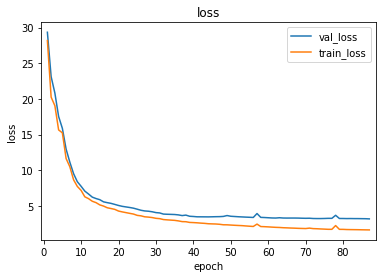

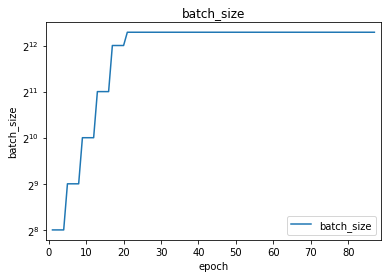

In [21]:
model.plot(['val_loss', 'train_loss'], 'loss', 'loss', scale='linear', basey=10)
model.plot(['batch_size'], 'batch_size', 'batch_size', scale='log', basey=2)

In [ ]:
best_model = classifier.load_model(from_file='checkpoint_V11_E081_0.952_SEED42.pth')
best_model.log

In [19]:
model.beam_stats[1]['matrix'][worst_tags].loc[worst_tags].T

,NN,JJ,NNP,RB,IN,VBN,NNS,VBD,VB,VBP,...,WP,-LRB-,TO,:,-RRB-,WRB,EX,WP$,``,SYM
NN,3133,94,15,11,3,5,9,3,18,12,...,0,0,0,0,0,0,0,0,0,0
JJ,112,1299,23,22,1,28,1,1,7,6,...,0,0,0,0,0,0,0,0,0,0
NNP,26,26,1916,0,3,0,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
RB,3,12,1,713,52,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,0
IN,2,1,0,18,2479,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
VBN,0,32,0,0,0,431,0,31,0,0,...,0,0,0,0,0,0,0,0,0,0
NNS,35,2,8,1,0,0,1432,0,0,0,...,0,0,0,0,0,0,0,0,0,0
VBD,2,8,1,0,0,33,0,791,2,6,...,0,0,0,0,0,0,0,0,0,0
VB,16,8,0,6,1,1,0,1,540,16,...,0,0,0,0,0,0,0,0,0,0
VBP,7,1,0,0,0,0,0,7,11,283,...,0,0,0,0,0,0,0,0,0,0


In [16]:
model.beam_stats[1]['worst']

{'NN': 0.9806116414632086,
 'JJ': 0.9823434991974318,
 'NNP': 0.9930725690631073,
 'RB': 0.9935372138210695,
 'IN': 0.9941285798766579,
 'VBN': 0.9943397820393681,
 'NNS': 0.9948044267973304,
 'VBD': 0.9959871589085072,
 'VB': 0.9960293993410493,
 'VBP': 0.9968319675593478,
 'NNPS': 0.9969164484244318,
 'VBG': 0.9969586888569739,
 'JJR': 0.9977190166427304,
 'VBZ': 0.9980146996705246,
 'RBR': 0.998479344428487,
 'DT': 0.9986483061586551,
 'RP': 0.9987750274562811,
 'CD': 0.9991129509166173,
 'WDT': 0.9992396722142435,
 'JJS': 0.9993663935118695,
 'RBS': 0.9995353552420376,
 'POS': 0.9996620765396638,
 'PDT': 0.9997465574047478,
 '#': 0.9997887978372898,
 'MD': 0.9997887978372898,
 'UH': 0.9998310382698319,
 'FW': 0.9998732787023739,
 'CC': 0.9998732787023739,
 'PRP': 0.9999155191349159,
 "''": 0.9999155191349159,
 'PRP$': 0.9999155191349159,
 '$': 0.9999577595674579,
 '.': 0.9999577595674579,
 ',': 1.0,
 'WP': 1.0,
 '-LRB-': 1.0,
 'TO': 1.0,
 ':': 1.0,
 '-RRB-': 1.0,
 'WRB': 1.0,
 'EX'

In [26]:
model.beam_stats = beam_stats
model.save()

In [ ]:
display(matrix1)
display(matrix2)

In [ ]:
display(worst1)
display(worst2)

### Code that may be useful

In [ ]:
# sentences = {}
# for sentence in train_dataset.sentences:
#     sentences[len(sentence[0])] = sentence

In [ ]:
# %%time
# sample_sentence = (['Terms', 'were', "n't", 'disclosed', '.'],  # sentence words
#                    ['NNS',   'VBD',  'RB',  'VBN',       '.'])  # sentence true tags
# predict_beam = 100  # viterbi beam size

# tags, bp_pi = viterbi(model, sample_sentence[0], beam=predict_beam)
# print('sentence ', sample_sentence[0])
# print('true tags', sample_sentence[1])
# print('pred tags', tags)
# print()

In [7]:
%%time
sum_vec = np.zeros(len(feature_vector)).astype(np.float32)
sum_inds = 0
for t2, t1, w, i, t in train_dataset:
    vec = feature_vector(t2, t1, w, i, t, fmt='vec')
    sum_vec += vec
    sum_inds += (vec).sum()

df = pd.DataFrame(sum_vec, columns=['feat']).astype({'feat': int}).sort_values('feat', ascending=False)
print(sum_vec.sum())
print(sum_inds/len(train_dataset.sentences))
display(df.head(50))

3802186.0
760.4372


,feat
32871,16939
42333,16939
42378,16939
42289,16939
42423,16939
...,...
7471,1
7472,1
13388,1
7476,1


CPU times: user 28.2 s, sys: 15.6 ms, total: 28.3 s
Wall time: 28.8 s


In [13]:
display(df.loc[0:100].head(50))

,feat
0,6199
17008,6199
19968,6199
42480,6044
24990,6044
19758,6044
20012,6044
56,6044
26421,6044
42299,6044


In [15]:
feat, key = feature_vector.invert_feat(4914)  # 41453 22811
print(feat)
print(key)


FeatureGroup(tuple([w[i].lower(), t]))
('low-density', 'NN')


In [ ]:
# # test run train_dataset
# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_vec_t = feature_vector(t2, t1, w, i, t, fmt='vec')
# print('fmt=vec: {:.3f} sec'.format(time.time() - tic))

# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_list_t = feature_vector(t2, t1, w, i, t, fmt='list')
# print('fmt=list: {:.3f} sec'.format(time.time() - tic))

# tic = time.time()
# for t2, t1, w, i, t in train_dataset:
#     feat_vec_t, feat_list_t = feature_vector(t2, t1, w, i, t, fmt='both')
# print('fmt=vec+list: {:.3f} sec'.format(time.time() - tic))

In [ ]:
# for tag in train1_statistics.words_per_tag:
#     if len(train1_statistics.words_per_tag[tag]) < 10:
#         print('{:5} tf: {:5d} unique_count: {:4d} words: {}'.format(tag, train1_statistics.tags_count[tag], len(train1_statistics.words_per_tag[tag]),
#                                                                     train1_statistics.words_per_tag[tag]))
#     else:
#         print('{:5} tf: {:5d} unique_count: {:4d}'.format(tag, train1_statistics.tags_count[tag], len(train1_statistics.words_per_tag[tag])))

In [ ]:
# features = []

# # one-to-one features
# for word in strange_words:
#     features.append(Feature(f'w[i] == "{word}"', t=train1_model.tags_per_word[word][0]))
#     print(word, train1_model.WordCount[word], train1_model.TagsPerWord[word])